# Computing decision boundary for geometric examples in dimension 2 and 3

In this notebook we will use gradient flow from gdeep.decision_boundary to compute the decision boundary of a neural network trained on a binary classification problem

In [69]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


import math

seed=42

import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F


from gtda.plotting import plot_point_cloud

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from gdeep.decision_boundary import *
from gdeep.neural_nets import Net
from gdeep.neural_nets.utility import train_classification_nn

## Example 1: Decision boundary for two circles in $\mathbb R^2$

We have constructed two data sets $A$ and $B$ with the labels $0$ and $1$. These are either concentric or separated from one another by adding `[2,0]` or not.

In [41]:
data, label = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=seed)

A = data[label==0]
B = data[label==1] #+ [2,0]

In [44]:
plot_point_cloud(np.concatenate((A, B)))

In [62]:
# define NN architecture
circle_detect = Net(0, [2,10,10])

# transform input data to 
X_train = torch.from_numpy(np.concatenate((A, B))).float()
y_train = torch.from_numpy(np.concatenate((np.ones(A.shape[0]),\
                np.zeros(B.shape[0])))).float()


# Train neural net on binary classification task
train_classification_nn(circle_detect, X_train, y_train, n_epochs=1000)

99 0.9412509799003601
199 0.6686216592788696
299 0.5377398729324341
399 0.3568928837776184
499 0.20962001383304596
599 0.12312001734972
699 0.07569002360105515
799 0.049490395933389664
899 0.034263692796230316
999 0.024776391685009003


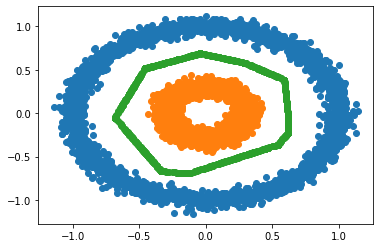

In [67]:
sample_points_boundary = gradient_flow(circle_detect, boundary_tuple=[(-1,1),(-1,1)])


plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1])
plt.scatter(sample_points_boundary[:,0],sample_points_boundary[:,1])

plt.show()

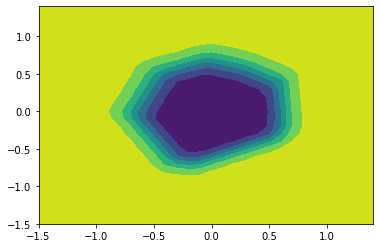

In [68]:
# Plot graph of circle_detect

delta = 0.1
x = np.arange(-1.5, 1.5, delta)
y = np.arange(-1.5, 1.5, delta)
X, Y = np.meshgrid(x, y)

X_tensor, Y_tensor = torch.from_numpy(X).float(), torch.from_numpy(Y).float()
X_tensor = X_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1],1))
Y_tensor = Y_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1],1))
XY_tensor = torch.cat((X_tensor,Y_tensor), 2)

XY_tensor = XY_tensor.reshape((-1,2))

Z_tensor = circle_detect.forward(XY_tensor)
Z_tensor = Z_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1]))
Z = Z_tensor.detach().numpy()
plt.contourf(X, Y, Z)


## Example 2: Decision boundary for two tori in $\mathbb R^3$

In [87]:
torus_pc_ent_1, torus_labels_ent_1 = make_torus_point_cloud(0, 50, 0.0,\
    Rotation(1,2,math.pi/2), np.array([[0,0,0]]), radius=.3)
torus_pc_ent_2, torus_labels_ent_2 = make_torus_point_cloud(1, 50, 0.0,\
    Rotation(1,2,0), np.array([[6,0,0]]), radius=.3)


import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

data_points_ent = np.concatenate((torus_pc_ent_1,torus_pc_ent_2), axis=0)
labels_ent = np.concatenate((torus_labels_ent_1,torus_labels_ent_2), axis=0)

ax.scatter(torus_pc_ent_1[:,0], torus_pc_ent_1[:,1], torus_pc_ent_1[:,2])
ax.scatter(torus_pc_ent_2[:,0], torus_pc_ent_2[:,1], torus_pc_ent_2[:,2])

plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [88]:
tori_detect = Net(0, [3,20,20,20,20])

X_train = torch.from_numpy(data_points).float()
y_train = torch.from_numpy(labels).float()

print('Architecture of Neural Net:\n', tori_detect)

train_classification_nn(tori_detect, X_train, y_train, n_epochs=2000)

Net(
  (layer0): Linear(in_features=3, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=1, bias=True)
)
99 0.0005111971986480057
199 4.112027818337083e-05
299 1.534264811198227e-05
399 9.91892557067331e-06
499 7.595734132337384e-06
599 6.597788797080284e-06
699 6.144627604953712e-06
799 5.9539916037465446e-06
899 5.766748472524341e-06
999 5.569060249399627e-06
1099 5.298342784954002e-06
1199 5.124553354107775e-06
1299 4.600631655193865e-06
1399 4.626328063750407e-06
1499 4.5663532546313945e-06
1599 4.436907147464808e-06
1699 4.309467385610333e-06
1799 4.228866600897163e-06
1899 4.169033218204277e-06
1999 4.120466655876953e-06


In [22]:
labels.shape

(5000,)

In [23]:
X_train.shape

torch.Size([5000, 3])

In [ ]:
# Plot decision boundary tori detect

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)

delta = 0.1
x = np.arange(-1.5, 1.5, delta)
y = np.arange(-1.5, 1.5, delta)
X, Y = np.meshgrid(x, y)

X_tensor, Y_tensor = torch.from_numpy(X).float(), torch.from_numpy(Y).float()
X_tensor = X_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1],1))
Y_tensor = Y_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1],1))
XY_tensor = torch.cat((X_tensor,Y_tensor), 2)

XY_tensor = XY_tensor.reshape((-1,2))

Z_tensor = circle_detect.forward(XY_tensor)#nn.Softmax(dim=0)(XY_tensor)[:,0]
Z_tensor = Z_tensor.reshape((X_tensor.shape[0],X_tensor.shape[1]))
#torch.div(torch.exp(XY_tensor)[:,:,0],torch.sum(torch.exp(XY_tensor), axis=2))
Z = Z_tensor.detach().numpy()
plt.contourf(X, Y, Z)

In [89]:
n_samples = 10000
sample_points = np.random.rand(n_samples, 3)

# disentangled
#sample_points = sample_points.dot(np.diag([10, 4, 4])) + np.array([-3,-2,-2])

# entangled
sample_points = sample_points.dot(np.diag([6, 4, 4])) + np.array([-2,-2,-2])

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample_points_new[:,0], sample_points_new[:,1], sample_points_new[:,2])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sample_points_new[:,0], sample_points_new[:,1], sample_points_new[:,2])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [91]:
# visualisation
import pandas as pd
import plotly.express as px
df_bd = pd.DataFrame(sample_points_new, columns = ["x", "y", "z"])
df_bd_t1 = pd.DataFrame(torus_point_clouds, columns = ["x", "y", "z"])
df_bd_t2 = pd.DataFrame(torus_point_clouds_2, columns = ["x", "y", "z"])

df_all = pd.concat([df_bd_t1, df_bd_t2, df_bd])

fig = px.scatter_3d(df_all, x="x", y="y", z="z", color=np.concatenate((0*np.ones(df_bd_t1.shape[0]),1*np.ones(df_bd_t2.shape[0]),2*np.ones(sample_points_new.shape[0]))))

fig.show()
#fig.write_html("separated_tori.html")

In [70]:
np.concatenate((0*np.ones(df_bd_t1.shape[0]),1*np.ones(df_bd_t2.shape[0]),2*np.ones(sample_points_new.shape[0])))

array([0., 0., 0., ..., 2., 2., 2.])

In [ ]:
# Save 3d plots to file

fig.write_html("outputs/unentangled_tori.html")